<a href="https://colab.research.google.com/github/wbwatkinson/AFIT-RI-MLBC/blob/main/CNN%20exemplar%20September.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Variant Machine Learning Problem    September 2021**

Today we move into the convolutional NN world with another fairly simple exemplar and a few new concepts to add to the mix.  This is a more individual notebook, and we'll get back to group interactions soon.

You can add visualization and data checking as in previous notebooks if you like, to get a sense of what the data is doing.  We are using a larger database of images and doing a bit of processing to get them ready for ingestion into the model.  The three tasks to be done are highlighted, and the four questions have empty markdown blocks underneath for you to enter your answers.  To answer the questions, just double-click on the "Your answer" text in the cell area and enter your answers.  Remember to save your final notebook and submit during/after our 1500 session. (Files/Part 1/Submitted Assignments Part1/Week 4../your folder)

The dataset will take a bit to download if you have a slow internet connection (but only the first time).  Things should work along without any errors.  Please don't wait until 2:00 pm to see if this runs -- check it out and then have lunch!  You should be spending about three hours on this to get the concepts down if you don't have problems.  Check first... 

Depending on your computer, it might take some time to do the training for larger numbers of epochs as you change parameters, do some timing runs to verify.  Another good reason to start early!


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pathlib, os
import seaborn as sns
import tensorflow as tf
import numpy as np 
import pandas as pd 


In [ ]:
# This dataset is retrieved by a keras utility that understands
# stored versions, including the one we are working on - Fashion MNIST
# (reference here: https://keras.io/api/datasets/fashion_mnist/)
# It is the "fashion" corollary to MNIST - 60,000 train/10,000 test
# grayscale images of 10 types of clothing.

fMNIST_data = tf.keras.datasets.fashion_mnist

In [ ]:
# set the train/test data, it is already segmented
(X_train, y_train), (X_test, y_test) = fMNIST_data.load_data()

# X_train[0] if you want to see the 28x28 pixel component of the first sample

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
# Check to make sure everything is correct
print(X_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


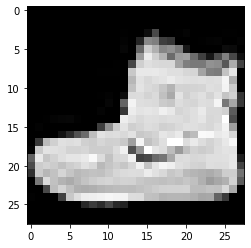

In [ ]:
# take advantage of the 'imshow()' method of matplotlib to check one out
plt.imshow(X_train[0], cmap='gray', vmin=0, vmax=255)

<p style="color:red">Question 1:</p>  Why is it an inverse image; shouldn't the background be white and the higher values represent darker tones? (*hint - print out the pixel values, as was done in the MNIST notebook, and think about processing the values*)

<p style="color:red">Your Answer 1:</p>  ?? (double-click here and edit...)


**Instructor Answer:** *Think about the math associated with muliplying lots of '255' values vice '0' values; multiplication by zero, or handling sparse versus dense matrices/vectors very much simplifies the work to be done.*

This is also a good time to re-iterate how NN's don't "see" like you and I do. The representation of the images is 28x28, and that is the world it knows.  How well would you do with the identification of some of the clothing objects?

In [ ]:
# same as the simple NN earlier, need to normalize the data between zero
# and one to help with calculations/normalization.  You could try without this
# to see what impact it has, but you'd still have to convert to floats
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [ ]:
# need to add a dimension to the array for the one grayscale channel,
# then we're ready to build the model
X_train = X_train.reshape((60000, 28, 28, 1))
X_test = X_test.reshape((10000, 28, 28, 1))

<p style="color:red">Question 1:</p>  Why do we add a dimension to the array, when it is already appropriate for display? (*silly hint -- you could comment the previous two lines out and see what happens... it does give you a little insight*)

<p style="color:red">Question 1:</p>  ?? (double-click here and edit...)

**Instructor answer:** *The extra 'dimension' is because we are using that space for the processing of the pixel values - we can't do the math without that column being there.  A picture renderer ( like 'imshow()') knows how to handle the picture formats automatically; we are using the 'dimension' explicitly in successive calculations.  As an exemplar, take out the 'cmap', 'vmin', and 'vmax' qualifiers from the imshow() code line above; you'll see that by default matplotlib tries to make it a 'color' picture, it looks quite different.  If you move the code for 'imshow()' to after the cell that adds the extra dimension, it will throw an error because of the extra dimension.  If you do comment out the two lines immediately above, you'll see that the 'model.fit' cell below will fail because it got an unexpected shape for input.*

In [ ]:
# We could also set up the categorical encoding for the y values as:
#y_train = tf.keras.utils.to_categorical(y_train)
#y_test = tf.keras.utils.to_categorical(y_test)
# as we have in previous work.  But we don't here.

<p style="color:red">Question 3:</p>  Why don't we use straight "categorical_crossentropy" as the loss function in the model below? (*hint:  it has something to do with larger and larger datasets/labelsets and scaling of compute, not just this notebook*)

<p style="color:red">Your answer 3:</p>  ?? (double-click here and edit...)

**Instructor answer:**  *Some general agreement and some dissenters, but there is a reason to expect less complexity in very large feature sets such that the 'one-hot' encoding (that is, a feature vector that looks like [0, 0, 1, 0, ....0, 0]) ends up being a very large space to operate over.  But then, there are sparse matrix operations that can help.  And, depending on configuration, that is what happens when you choose sparse_categorical_crossentropy.  Mostly affects very large feature sizes (like word vectors).  This is a discussion opportunity to talk about data and scaling.*

Let's talk about the network we are going to build.  If you recall from the introductory session those two long weeks ago, we looked at three basic types of NN architecture; Fully Connected (called Dense now...), Convolutional, and Recurrent.  The reason for choosing those three was to highlight what foundational basis they had for "solving problems."  
1. The FC network is pretty good for most things that need NN solutions where lots of basic matrix/vector manipulations (regression, "prediction", classification based strictly on column vectors of sample features).  
2. Convolution is based on the foundational idea that there is a need to take *extent* into account -- where things are in relation to other things in a "snapshot" distance sense (like 2D pictures or other higher-dimension object-spaces).  
3. Recurrent is based on the idea that there is a need to take *sequence* into account, be it in the sense of a time series of digitized signal measurements, or a sequence of written or spoken words where the correlation between data samples requires a memory aspect associated with before/after relationships.
The purpose in selecting these three was not to constrain our work to these specific models, but to understand the reasoning underneath the models and extend that reasoning to newer architectural approaches that are solving the same class of problems.  



A quick graphic on some of the dimensional manipulations for the first convolutional layer that might help -

**This graphic is not the best; it fits here because the cohort has already seen this process in a slide brief and talked through it**

<img src='https://github.com/wbwatkinson/AFIT-RI-MLBC/blob/main/conv2d.JPG?raw=1' />

**Task 1**
Below is the model build for the Convolutional NN.  Find out how it performs.  Experiment with each of the activation functions, the loss functions, and the optimizers in the list below.  Don't modify other aspects just yet.  This code runs fairly quickly with low numbers of epochs, try various combinations.  It is easy to get better results, harder to get "almost" 100%. 
1.  Activation functions: sigmoid, tanh, relu; note the relu to start.  Probably the best choice,  but what would you choose and why?
2.  Loss functions: mean squared error, binary cross entropy, categorical cross entropy.  
3.  Optimizers: SGD, Adam.  Here again SGD is good to start things going, what does Adam do for you?  There is a default learning rate for Adam, but you can change it with a parameter setting.  Try a couple to get a little better result.

**Task 2**
Add a second convolutional layer and see if you can get a little closer to the 100% mark.  Try comparing fewer epochs with the additional layer and see if it correlates with the single Conv2D with a few more epochs.

In [ ]:
# build a sequential model that is much more complex than yesterady

model = tf.keras.Sequential()

# add the first layer (it has to match the input features - the 'input shape'
# below - they are 28x28 scaled pixel values)
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 2,
                                 padding = 'same', activation = 'relu',
                                 input_shape = (28,28,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size = 2))
model.add(tf.keras.layers.Dropout(0.3))

# another "layer set" for Conv2d goes here  - Task 2

# After the convolution layer(s), we need to get back to a linear sample
model.add(tf.keras.layers.Flatten()) #(note no 'parameters' at all)
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

# and the final output layer
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# select an optimizer
optimizer = tf.keras.optimizers.SGD()
# select a loss function
loss = 'sparse_categorical_crossentropy'

In [ ]:
#Compile the model

model.compile(loss=loss,
              optimizer=optimizer,
              metrics =['accuracy'])

# view a summmary of the model (textual summary) showing details
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               3211520   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2

<p style="color:red">Question 4:</p>  Can you break down the calculation of parameters *and the output shape* above?  You should have a head start, with the dense layer (from last week).  Just need to ponder the convolutional layer, and where the weights are, and the flattening.  Not magic, just math.

<p style="color:red">Your answer 4:</p>  ?? (double-click here and edit...)

**Instructor answer:**  *320 = 2 * 2 * 64 [filter wxh times num_filters] plus 64 (bias); flatten is just 14 * 14 * 64.  Dense 2 is 12544 * 256 + 256.  Final is 256 * 10 + 10.*  

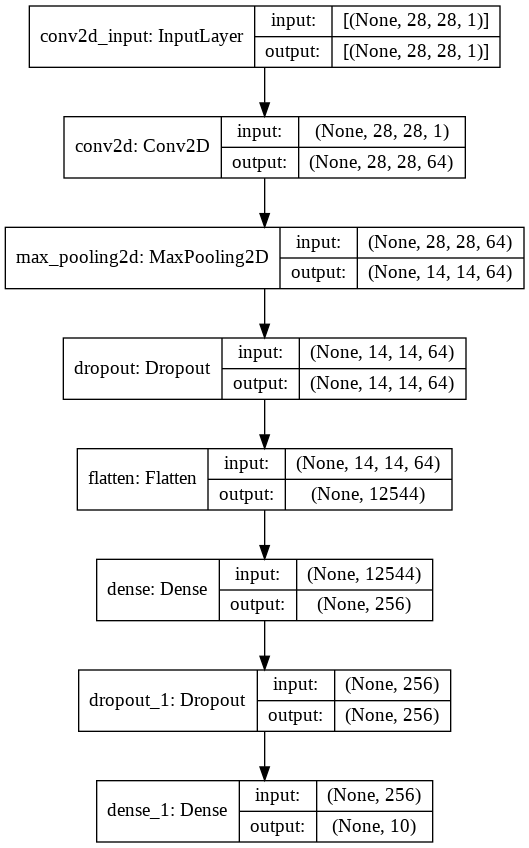

In [ ]:
# Show a visual representation of the model using a keras utility
# You also need to have pydot and graphvis installed for this to work
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)


In [ ]:
fMNIST_model = model.fit(X_train, y_train, batch_size=64, epochs=2, verbose=2)

Epoch 1/2
938/938 - 34s - loss: 0.9948 - accuracy: 0.6542
Epoch 2/2
938/938 - 3s - loss: 0.6187 - accuracy: 0.7758


In [ ]:
eval = model.evaluate(X_test, y_test, verbose=0) 
print("\nLoss, accuracy on test data: ")
print("%0.4f %0.2f%%" % (eval[0],eval[1]*100))


Loss, accuracy on test data: 
0.5257 80.81%


**Task 3**
Show output on a sequence of 10 images in the test dataset and whether or not they were correct.  Your choice of method - if you are time constrained, just use text and show that it is (mostly) as you would expect given the accuracy results you obtained above.  If you want to exercise the multiple sub-figure plotting (from previous notebook, or your own), you can certainly do that.  